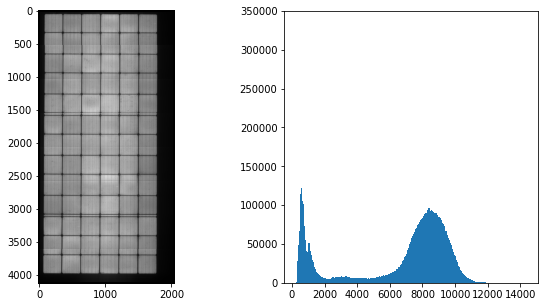

In [3]:
''' Creation: 2021.09.26
    Last update: 2021.10.01
    
    Electroluminecence greateyes raw images reading and plotting 
    
    '''

# Standard library import
import os.path
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt
import numpy as np

#Internal import 
import PVcharacterization_Utils as pv

file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              ]
file_name = file_names[1]

file = pv.DEFAULT_DIR / Path("PVcharacterization_files") / Path(file_name)

borne_sup = np.Inf
borne_inf = 800
filter_image = False

electrolum = pv.read_electolum_file(file,pack=True)

if len(electrolum.image) > 1:
    fig = plt.figure(figsize=(16,12))
    gs = fig.add_gridspec(7,2, hspace=0.5, wspace=0)
    axe = gs.subplots(sharex='col')
    for index, image in enumerate(electrolum.image):
        #if index == 6 : break
        
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
            

        axe[index,0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[index,0].spines[axis].set_linewidth(0)
        
        image_flatten = image.flatten()
        if filter_image :image_flatten = image_flatten[image_flatten != 0]
        _ = axe[index,1].hist(image_flatten, bins='auto')
        axe[index,1].set_ylim([0,50000])
        
        file_gsf = os.path.splitext(file_name)[0] + '_' + str(index+1) + '.gsf'
        file = pv.DEFAULT_DIR / Path("PVcharacterization_files") / Path(file_gsf)
        pv.py2gwyddion(image, file)
        

else: # Full image treatment
    fig,axe = plt.subplots(1,2,figsize=(10,5))
    for index, image in enumerate(electrolum.image):
        if filter_image : image = np.where((image < borne_inf) | ( image > borne_sup), 0, image)
        axe[0].imshow(image,
                   cmap='gray', 
                   interpolation=None)
        for axis in ['top','bottom','left','right']:
            axe[0].spines[axis].set_linewidth(2)
            
        image_flatten = image.flatten()
        if filter_image : image_flatten = image_flatten[image_flatten != 0]
        
        _ = axe[1].hist(image.flatten(), bins='auto')
        axe[1].set_ylim([0,7*50000])
    
        file_gsf = os.path.splitext(file_name)[0] + '.gsf'
        file = pv.DEFAULT_DIR / Path("PVcharacterization_files") / Path(file_gsf)
        pv.py2gwyddion(image, file)

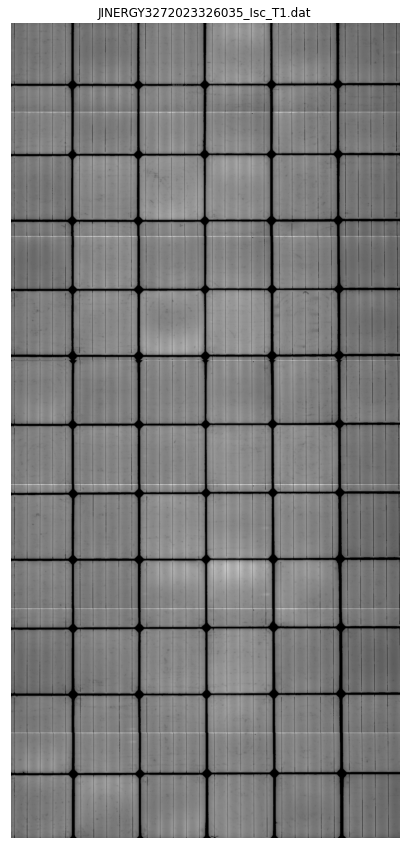

In [4]:
''' Creation: 2021.09.26
    Last update: 2021.10.01
    
    Electroluminecence greateyes raw images reading, croping and plotting 
    
    '''

# Standard library import
import os
from pathlib import Path

# 3rd party imports
import matplotlib.pyplot as plt

#Internal import 
import PVcharacterization_Utils as pv


NCOLS_SUPPRESS = 10

# Reads, crops and stitches the set of electroluminesence images acquired with greateyes camera
file_names = ["SERAPHIM-EM-0640_Isc_ap500hXDH.dat",
              "JINERGY3272023326035_Isc_T2.dat",
              "JINERGY3272023326035_Isc_T1.dat",
              ]
file_name = file_names[2]

file = pv.DEFAULT_DIR / Path("PVcharacterization_files") / Path(file_name)

croped_image = pv.crop_image(file)

# Plots the image throwing away the NCOLS_SUPPRESS first columns
fig,axe = plt.subplots(1,1,figsize=(15,15))
axe.imshow(croped_image[:,NCOLS_SUPPRESS:],
           cmap='gray', 
           interpolation=None)
for axis in ['top','bottom','left','right']:
            axe.spines[axis].set_linewidth(0)
axe.set_xticklabels([])
axe.set_yticklabels([])
axe.set_xticks([])
axe.set_yticks([])
plt.title(file_name)

# Dumps the image in Gwyddion Simple Field Files format
file_gsf = os.path.splitext(file_name)[0] + '_full.gsf'
file = pv.DEFAULT_DIR / Path("PVcharacterization_files") / Path(file_gsf)
pv.py2gwyddion(croped_image, file) 